In [38]:
pip install imblearn


   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   --- ----------------------------------- 20.5/258.0 kB 320.0 kB/s eta 0:00:01
   ---------- ---------------------------- 71.7/258.0 kB 558.5 kB/s eta 0:00:01
   ---------------------------------------  256.0/258.0 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 258.0/258.0 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from six.moves import urllib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf


In [2]:
df = pd.read_excel('confirmed_recurrence.xlsx')

columns_to_drop = ['Sample ID', 'Other Patient ID', 'Form completion date', 'Tissue Source Site',
                   'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
                   'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',
                   'American Joint Committee on Cancer Publication Version Type', 'ICD 10 Classification',
                   'ICD-O-3 Histology Code', 'ICD-O-3 Site Code', 'AJCC Publication Version Type']

# Check if the columns exist in the DataFrame before dropping
columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

if columns_to_drop_existing:
    # Drop the specified columns
    df.drop(columns=columns_to_drop_existing, inplace=True)
    
    df.to_excel(output_excel_file, index=False)

identical_columns = [col for col in df.columns if df[col].nunique() == 1]

# Print the names of columns with identical data
print("Columns with identical data:", identical_columns)

# Drop these columns from the DataFrame
df = df.drop(columns=identical_columns)


Columns with identical data: ['Sex', 'STATUS_for_status_1', 'CLINICAL_STAGE_for_status_2', 'CLINICAL_STAGE_for_status_3', 'INITIAL_PATHOLOGIC_DIAGNOSIS_METHOD_for_status_2', 'INITIAL_PATHOLOGIC_DIAGNOSIS_METHOD_for_status_3', 'ANATOMIC_SITE_for_status_1', 'TUMOR_STATUS_for_status_1', 'PRIMARY_THERAPY_OUTCOME_SUCCESS_for_status_1', 'VITAL_STATUS_for_status_1', 'TREATMENT_START_DATE_for_treatment_9', 'TREATMENT_START_DATE_for_treatment_10', 'TREATMENT_START_DATE_for_treatment_11', 'TREATMENT_START_DATE_for_treatment_12', 'TREATMENT_STOP_DATE_for_treatment_9', 'TREATMENT_STOP_DATE_for_treatment_10', 'TREATMENT_STOP_DATE_for_treatment_11', 'TREATMENT_STOP_DATE_for_treatment_12', 'TREATMENT_for_treatment_9', 'TREATMENT_for_treatment_10', 'TREATMENT_for_treatment_11', 'TREATMENT_for_treatment_12', 'AGENT_for_treatment_9', 'AGENT_for_treatment_10', 'AGENT_for_treatment_11', 'AGENT_for_treatment_12', 'NUMBER_OF_CYCLES_for_treatment_4', 'NUMBER_OF_CYCLES_for_treatment_5', 'NUMBER_OF_CYCLES_for_

In [3]:
data = df
data.describe()

,Diagnosis Age,Overall Survival (Months),Months of disease-specific survival,Progress Free Survival (Months),ANEUPLOIDY_SCORE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,TMB_NONSYNONYMOUS,TUMOR_WEIGHT,TREATMENT_START_DATE_for_treatment_1,...,COURSE_NUMBER_for_treatment_4,COURSE_NUMBER_for_treatment_5,NUMBER_OF_FRACTIONS_for_treatment_1,NUMBER_OF_FRACTIONS_for_treatment_2,NUMBER_OF_FRACTIONS_for_treatment_3,RADIATION_DOSAGE_for_treatment_1,RADIATION_DOSAGE_for_treatment_2,RADIATION_DOSAGE_for_treatment_3,RADIATION_DOSAGE_for_treatment_4,RADIATION_DOSAGE_for_treatment_5
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,...,25.00,25.00,25.000000,25.000000,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,64.280000,37.068744,37.068744,24.229871,11.800000,0.390548,3.576800,10.845333,292.960000,230.560000,...,0.04,0.04,1.360000,1.080000,2.56000,508.000000,248.000000,864.792000,417.600000,360.000000
std,9.048573,20.750778,20.750778,18.175336,8.154753,0.244498,8.249204,25.207386,372.006102,502.024408,...,0.20,0.20,5.081666,4.999333,7.11852,1508.840615,1018.626526,1853.642382,1460.220531,1278.997003
min,35.000000,14.038202,14.038202,4.306802,0.000000,0.278400,0.000000,0.000000,19.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,21.895650,21.895650,12.624519,5.000000,0.292200,0.220000,1.366667,128.000000,59.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65.000000,32.711970,32.711970,20.153204,11.000000,0.302100,0.430000,1.766667,177.000000,75.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,69.000000,39.517375,39.517375,29.457211,18.000000,0.323400,0.730000,3.600000,250.000000,92.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,82.000000,102.311208,102.311208,88.963409,26.000000,1.115200,26.900000,113.900000,1800.000000,2419.000000,...,1.00,1.00,25.000000,25.000000,25.00000,6000.000000,5000.000000,6000.000000,5940.000000,5500.000000


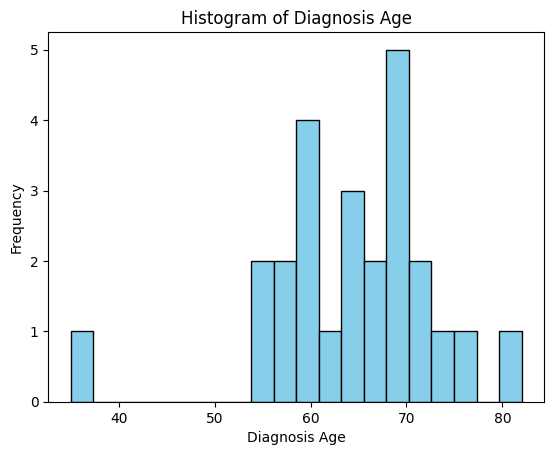

In [4]:
import matplotlib.pyplot as plt

# Histogram for Diagnosis Age
plt.hist(df['Diagnosis Age'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Diagnosis Age')
plt.ylabel('Frequency')
plt.title('Histogram of Diagnosis Age')
plt.show()


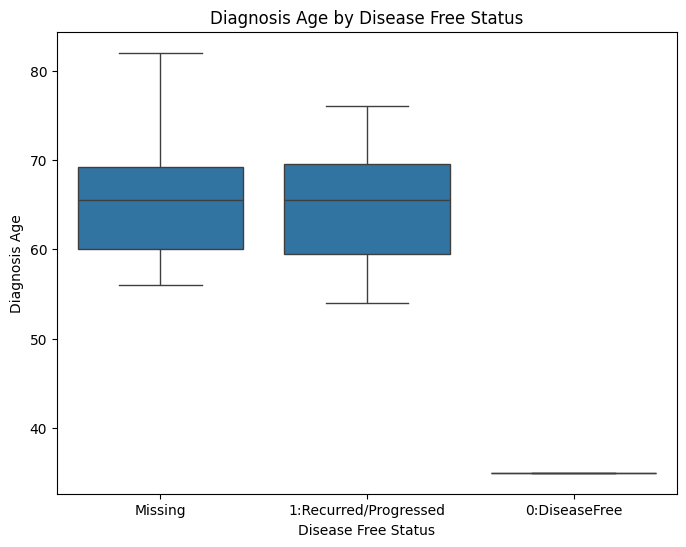

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot for Diagnosis Age by Disease Free Status
plt.figure(figsize=(8, 6))
sns.boxplot(x='Disease Free Status', y='Diagnosis Age', data=df)
plt.xlabel('Disease Free Status')
plt.ylabel('Diagnosis Age')
plt.title('Diagnosis Age by Disease Free Status')
plt.show()


In [8]:
columns_with_missing_values = data.columns[data.isnull().any()]

# Print the names of columns with missing values
print("Columns with missing values:")
for col in columns_with_missing_values:
    print(col)

# Optionally, you can also print the number of missing values in each column
print("\nNumber of missing values in each column:")
print(data.isnull().sum())

Columns with missing values:

Number of missing values in each column:
PATIENT_ID                                                           0
Diagnosis Age                                                        0
Last Communication Contact from Initial Pathologic Diagnosis Date    0
New Neoplasm Event Post Initial Therapy Indicator                    0
Person Neoplasm Cancer Status                                        0
                                                                    ..
RADIATION_UNITS_for_treatment_1                                      0
RADIATION_UNITS_for_treatment_2                                      0
RADIATION_UNITS_for_treatment_3                                      0
RADIATION_UNITS_for_treatment_4                                      0
RADIATION_UNITS_for_treatment_5                                      0
Length: 154, dtype: int64


In [9]:
data_xgboost = data.copy()

In [13]:
data = data.dropna(subset=['Disease Free Status'])
print(data.shape[0])
print(data.shape[1])
data_cleaned = data.dropna(axis=1, how='any')
print(data_cleaned.shape[0])
print(data_cleaned.shape[1])
data_shuffled = data_cleaned.sample(frac=1, random_state=42)


# Features (X) are all columns except 'ID' and 'Stage'
X = data_shuffled.drop(['Sample', 'Disease Free Status'], axis=1)

# Target variable (y) is 'Stage'
y = data_shuffled['Disease Free Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

25
154
25
154


KeyError: "['Sample Id'] not found in axis"

In [14]:
classifier_dt = DecisionTreeClassifier(random_state=42)
classifier_hgb = HistGradientBoostingClassifier(random_state=42)
classifier_mnb = MultinomialNB()
classifier_knn = KNeighborsClassifier()
classifier_gb = GradientBoostingClassifier(random_state=42)

In [15]:
# Create an ensemble model using majority voting
ensemble_classifier = VotingClassifier(
    estimators=[
        ('dt', classifier_dt),
        ('hgb', classifier_hgb),
        ('mnb', classifier_mnb),
        ('knn', classifier_knn),
        ('gb', classifier_gb)
    ],
    voting='soft' 
)

In [16]:
# Train the classifiers
for classifier in (classifier_dt, classifier_hgb, classifier_mnb, classifier_knn, 
                   classifier_gb, 
                   ensemble_classifier):
    classifier.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [17]:
y_pred_dt = classifier_dt.predict(X_test)
y_pred_hgb = classifier_hgb.predict(X_test)
y_pred_mnb = classifier_mnb.predict(X_test)
y_pred_knn = classifier_knn.predict(X_test)
y_pred_gb = classifier_gb.predict(X_test)
y_pred_ensemble = ensemble_classifier.predict(X_test)

NameError: name 'X_test' is not defined

In [18]:
# Evaluate the individual classifiers
for name, y_pred in zip(('Decision Tree', 'Hist Gradient Boosting', 'Multinomial Naive Bayes', 'k-NN', 
                         'Gradient Boosting', 
                         'Ensemble'), 
                        (y_pred_dt, y_pred_hgb, y_pred_mnb, y_pred_knn, 
                         y_pred_gb, 
                         y_pred_ensemble)):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

NameError: name 'y_pred_dt' is not defined

In [19]:
# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f}")

NameError: name 'y_test' is not defined

In [20]:
# Display the classification report for the ensemble model
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))


Ensemble Classification Report:


NameError: name 'y_test' is not defined

In [21]:
# Display the classification report for the ensemble model
print("\nEnsemble Classification Report:")
report_dict = classification_report(y_test, y_pred_ensemble, output_dict=True, labels=np.unique(y))
print(f"Sensitivity: {report_dict['1']['recall']:.4f}")
print(f"Specificity: {report_dict['0']['recall']:.4f}")


Ensemble Classification Report:


NameError: name 'y_test' is not defined

In [22]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print(conf_matrix)

NameError: name 'y_test' is not defined

In [23]:
from sklearn.inspection import permutation_importance

# Assuming 'Excluded_Column' is the column to exclude
excluded_column = 'Progression Free Status'

# Remove the excluded column from the feature names
feature_names = X.columns.tolist()
if excluded_column in feature_names:
    feature_names.remove(excluded_column)

# Assuming the classifier has already been trained and feature_importances_dt is available
feature_importances_dt = classifier_dt.feature_importances_

# Remove the excluded column from the feature importances
excluded_idx = X.columns.get_loc(excluded_column)
feature_importances_dt = np.delete(feature_importances_dt, excluded_idx)

# Calculate permutation importances
results = permutation_importance(classifier_hgb, X_test, y_test, n_repeats=10, random_state=42)

# Remove the excluded column from permutation importances
importances = np.delete(results.importances_mean, excluded_idx)
sorted_indices = np.argsort(importances)

# Visualize the Decision Tree feature importances
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), feature_importances_dt[sorted_indices], color='skyblue')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Decision Tree')
plt.show()

# Visualize the permutation importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_indices)), importances[sorted_indices], color='dodgerblue')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Mean Decrease in Accuracy')
plt.title('Feature Importance (Permutation) for HistGradientBoostingClassifier')
plt.show()

NameError: name 'X' is not defined

In [ ]:
from sklearn.inspection import permutation_importance

# Select a model for which you want to check feature importance
results = permutation_importance(classifier_dt, X_test, y_test, random_state=42)

# Get importance scores
importances = results.importances_mean

# Print feature importances
print("Permutation Importances:")
print(dict(zip(feature_names, importances)))
sorted_indices = np.argsort(importances)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), importances[sorted_indices], color='dodgerblue')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Decrease in Model Accuracy')
plt.title('Permutation Importances for Decision Tree')
plt.show()


In [ ]:
average_importances = (feature_importances_dt + importances) / 2

# Print and visualize the average feature importances
feature_importance_dict = dict(zip(feature_names, average_importances))
print("Average Feature Importances from Tree-based Models in Ensemble:")
print(feature_importance_dict)

# Visualization
sorted_indices = np.argsort(average_importances)
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), average_importances[sorted_indices], color='lightcoral')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Average Feature Importance')
plt.title('Average Feature Importances from Tree-based Models in Ensemble')
plt.show()


In [ ]:
import shap

# Create the SHAP Explainer
explainer = shap.Explainer(classifier_hgb, X_train)

# Calculate SHAP values with additivity check turned off
shap_values = explainer(X_test, check_additivity=False)

# Plot summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


In [ ]:
from scipy.stats import chi2_contingency, ttest_ind

data_copy = data.copy()

# Drop rows with missing 'Disease Free Status' (if not already done)
data_copy = data_copy.dropna(subset=['Disease Free Status'])

# Separate the target variable
target = 'Disease Free Status'
X = data_copy.drop(['Patient ID', target], axis=1)
y = data_copy[target]

In [ ]:
categorical_features = ['Cancer Type Detailed', 'Overall Survival Status', 'Disease-specific Survival status', 
                        'Progression Free Status', 'Ethnicity Category', 'Race Category', 'Subtype', 
                        'Tumor Type', 'Genetic Ancestry Label', 'ICD-10 Classification', 'In PanCan Pathway Analysis', 
                        'Informed consent verified', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 
                        'New Neoplasm Event Post Initial Therapy Indicator', 'Person Neoplasm Cancer Status', 
                        'Prior Diagnosis', 'Radiation Therapy_x', 'Sex', 'TCGA PanCanAtlas Cancer Type Acronym', 
                        'Sample Type', 'Oncotree Code', 'Somatic Status', 'Tissue Prospective Collection Indicator', 
                        'Tissue Retrospective Collection Indicator', 'Tissue Source Site Code', 'Cancer Type', 
                        'Chemotherapy', 'Hormone Therapy', 'Not Specified', 'Other', 'Radiation Therapy', 
                        'Targeted Molecular Therapy']

chi2_results = []
for col in categorical_features:
    if col in data_copy.columns:
        contingency_table = pd.crosstab(data_copy[col], data_copy[target])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        chi2_results.append((col, chi2, p))

In [ ]:
continuous_features = ['Mutation Count', 'Fraction Genome Altered', 'Diagnosis Age', 'MSI MANTIS Score', 
                       'MSIsensor Score', 'Birth from Initial Pathologic Diagnosis Date', 'Buffa Hypoxia Score', 
                       'Disease Free (Months)', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 
                       'Last Communication Contact from Initial Pathologic Diagnosis Date', 'Months of disease-specific survival', 
                       'Number of Samples Per Patient', 'Overall Survival (Months)', 'Patient Weight', 'Progress Free Survival (Months)', 
                       'Ragnum Hypoxia Score', 'Winter Hypoxia Score', 'Aneuploidy Score', 'TMB (nonsynonymous)', 
                       'Neoplasm Histologic Grade']

ttest_results = []
for col in continuous_features:
    if col in data_copy.columns:
        group0 = data_copy[data_copy[target] == 0][col].dropna()
        group1 = data_copy[data_copy[target] == 1][col].dropna()
        t_stat, p_val = ttest_ind(group0, group1)
        ttest_results.append((col, t_stat, p_val))

In [ ]:
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'p-value']).sort_values(by='p-value')
ttest_df = pd.DataFrame(ttest_results, columns=['Feature', 't-statistic', 'p-value']).sort_values(by='p-value')

# Visualize Chi-square test results
plt.figure(figsize=(12, 8))
plt.barh(chi2_df['Feature'], chi2_df['p-value'], color='skyblue')
plt.xlabel('p-value')
plt.ylabel('Feature')
plt.title('Chi-square Test p-values for Categorical Features')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE

data_shuffled = data_xgboost.sample(frac=1, random_state=42)

# Features (X) are all columns except 'Patient ID' and 'Disease Free Status'
X = data_shuffled.drop(['Patient ID', 'Disease Free Status'], axis=1)

# Target variable (y) is 'Disease Free Status'
y = data_shuffled['Disease Free Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_clf.fit(X_train, y_train)


In [ ]:
y_pred = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


In [ ]:
data_copy = data.copy()

# Drop rows with missing 'Disease Free Status'
data_copy = data_copy.dropna(subset=['Disease Free Status'])

# Fill missing values (use appropriate methods as discussed previously)
data_copy.fillna(method='ffill', inplace=True)

# Separate the target variable
target = 'Disease Free Status'
X = data_copy.drop(['Patient ID', target], axis=1A)
y = data_copy[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_clf.fit(X_train, y_train)

excluded_column = 'Excluded_Column'
columns = X.columns.tolist()
columns.remove(excluded_column)

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': columns,
    'Importance': importance
})
# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Disease Free Status Classification')
plt.gca().invert_yaxis()
plt.show()
